#Quick Demonstration of 1st order propagation in Synergia

The most basic lattice propagation in Synergia is acheived by using a 1st order symplectic map. This notebook briefly considers this approach using a model lattice and produces some consistent diagnostics to detail the physics captured by the linear map. 

In [3]:
%load_ext watermark
%load_ext autoreload
%autoreload 2

In [4]:
%watermark -d -v -a "Nathan Cook"

Nathan Cook 15/07/2015 

CPython 2.7.10
IPython 3.1.0


In [5]:
import sys, os
import synergia
from mpi4py import MPI
import synergia_workflow

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
#Add options

def make_opts(name, order, outputdir):
    '''A quick function for defining a Synergia options object for map propagator comparisons.'''

    opts = synergia_workflow.Options(name)
    opts.add("map_order", order, "Map order", int)
    opts.add("output_dir",outputdir,"Directory for output files", str)
    
    #opts.add("map_order", 1, "Map order", int)
    opts.add("steps", nsteps, "Number of steps per turn", int)
    opts.add("steps_per_element",nsteps_per_element,"Number of steps per element", int)


    opts.add("verbosity", 1, "Verbosity of propagation", int)
    opts.add("turns", 100, "Number of turns", int)
    opts.add("maxturns", 200, "Maximum number of turns to run before checkpointing and quitting", int)
    opts.add("checkpointperiod", 300, "Number of turns to run between checkpoints", int)


    opts.add("emitx", 2.5e-6, "real sigma Horizontal emittance [m rad]", float)
    opts.add("emity", 2.5e-6, "real sigma Vertical emittance [m rad]", float)
    opts.add("stdz", 10.0, "sigma read z [m]", float)
    opts.add("dpop", 0.0, "Delta-p/p spread", float)

    opts.add("macro_particles", 1000, "Number of macro particles", int)
    opts.add("real_particles", 1.0e11, "Number of real particles", float)
    opts.add("tracked_particles", 100, "Number of tracked particles", int)
    opts.add("seed", 349250524, "Pseudorandom number generator seed", int)


    #space charge additions

    opts.add("gridx", 64, "grid points in x for solver", int)
    opts.add("gridy", 64, "grid points in y for solver", int)
    opts.add("gridz", 64, "grid points in z for solver", int)

    #options for controlling chef propagation vs. chef mapping!
    opts.add("use_maps", "all", "use maps for propagation either all, none, onlyrf, nonrf")
    #opts.add("allmaps", False, "Use all maps for propagation", bool)
    #opts.add("stepper", "splitoperator",
    #         "Simulation stepper, either 'independent','elements','splitoperator','soelements'", str)
    
    return opts

def make_path(dirname):
    '''Create a directory with the specified name - avoid race conditions if possible'''

    try:
        os.makedirs(dirname)
    except OSError:
        if os.path.exists(dirname):
            # We are nearly safe
            pass
        else:
            # There was an error on creation, so make sure we know about it
            raise
            
def cleanup(dirname):
    '''Cleanup files after run and move diagnostic outputs to proper directory.
    
    Arguments:
        -dirname: This is the relative path - e.g. full path = pwd + dirname
    
    '''
    curdir = os.getcwd()
    newdir = os.getcwd() + dirname
    
    for filename in os.listdir(curdir):
        if filename.endswith('.h5'):
            try:
                oldfn = '/'.join((curdir,filename))
                newfn = '/'.join((curdir,dirname,filename))
                #don't worry about shutil here, keep simple with os module
                os.rename(oldfn,newfn)
            except OSError:
                if os.path.exists(newfn):
                    #file already exists so delete and re-try
                    os.remove(newfn)
                    os.rename(oldfn,newfn)
                else:
                    #perhaps trying to move to a new disk or something that os can't handle
                    raise

##Linear Lattice with 1st order propagator

First we consider just the linear lattice.

In [21]:
#load lattice
lattice = synergia.lattice.Mad8_reader().get_lattice("model16", "/Users/ncook/Synergia_Tests/lattices/foborodobo_NL.lat")

length = lattice.get_length()
ref = lattice.get_reference_particle() #reference particle
ds = 0.01
nsteps = int(length/ds) +1 #calculate # of steps to take per turn
nsteps_per_element = nsteps/len(lattice.get_elements()) #not this isn't using future division, so returns int

In [22]:
name = 'model-linear'
order = 1
outputdir = 'order_'+str(order)+'_'+name

opts = make_opts(name, order, outputdir)
make_path(outputdir)

lattice_simulator = synergia.simulation.Lattice_simulator(lattice,
                                                              opts.map_order)
stepper= synergia.simulation.Independent_stepper(lattice, opts.map_order, opts.steps)

In [23]:
# Define a bunch simulator
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

# Define a set of bunch diagnostics

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#tracking diagnostics - PER STEP
diagnostics = synergia.bunch.Diagnostics_track("track.h5", opts.tracked_particles, opts.output_dir)
#Track a particle twice per turn (e.g. every ~ num_steps/2 add the diagnostic)
bunch_simulator.add_per_step(diagnostics)

#particle diagnostics - PER TURN
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag)

In [24]:
propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator, opts.turns, opts.maxturns, 
                     opts.verbosity)

###Single Particle Diagnostics

We should say very stable behavior from this lattice. We'll plot some poincare sections and calculate the single particle invariant throughout the simulation.

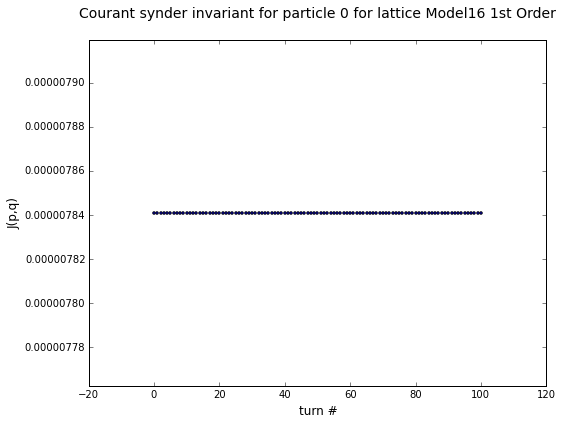

In [53]:
#clean up files first
#cleanup(outputdir)

from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = 'Model16 1st Order'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.01
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir


singleparticle.plot_Invariant(popts)

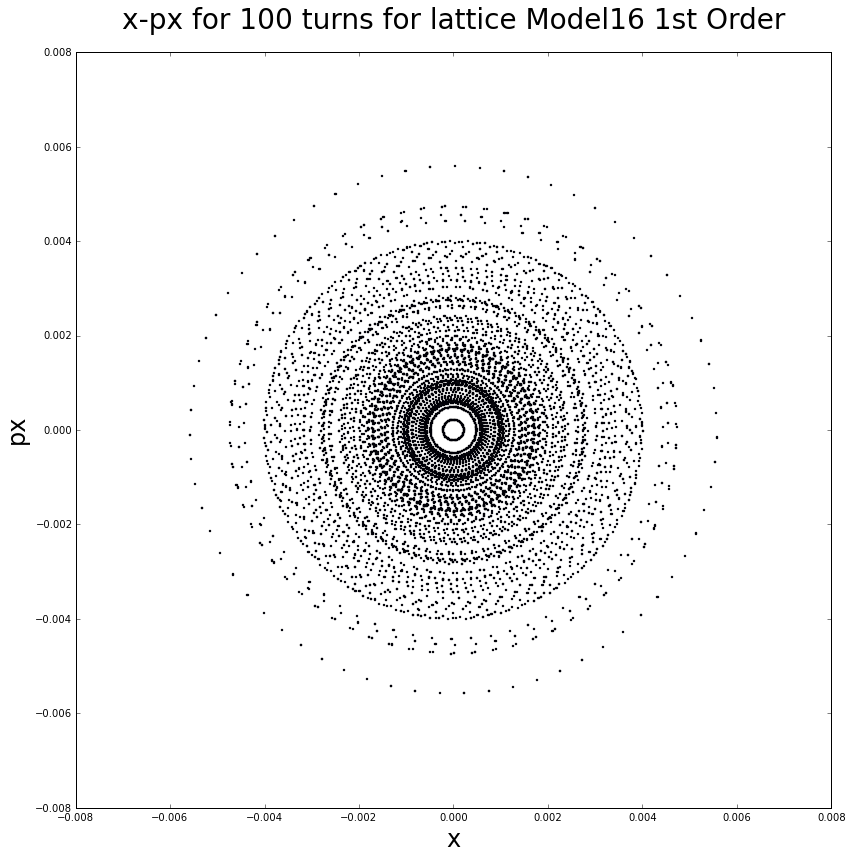

In [54]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = 'Model16 1st Order'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.01
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir

popts.save = True
popts.plots = ['x','px']
popts.num = 100
popts.scale = 2

singleparticle.plot_Poincare(popts)

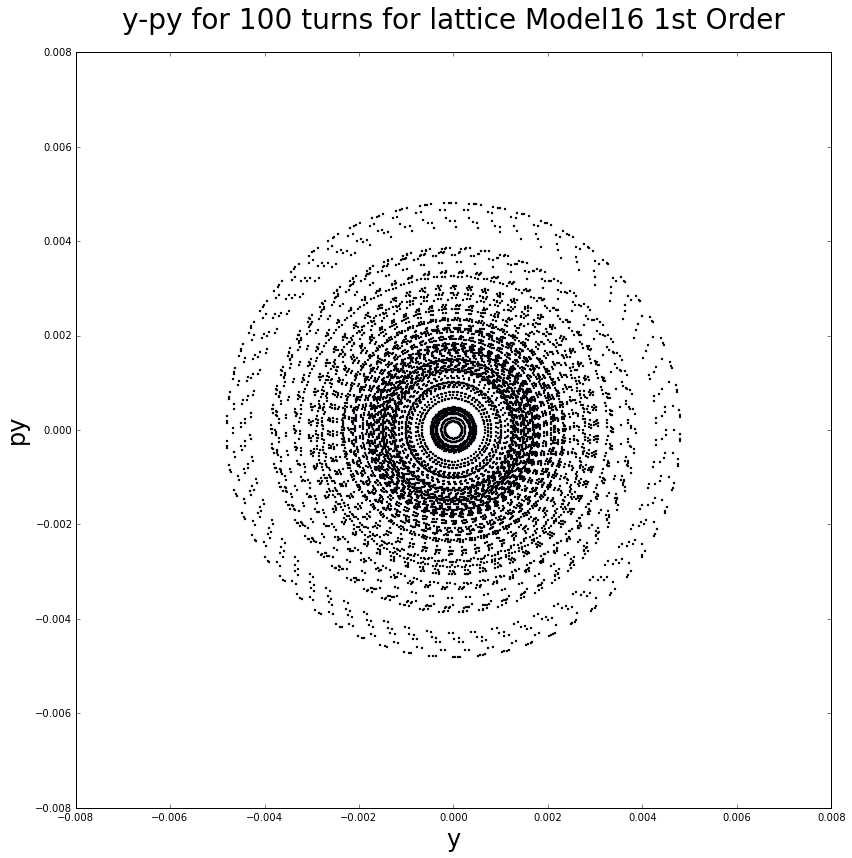

In [55]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = 'Model16 1st Order'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.01
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir

popts.save = True
popts.plots = ['y','py']
popts.num = 100
popts.scale = 2

singleparticle.plot_Poincare(popts)

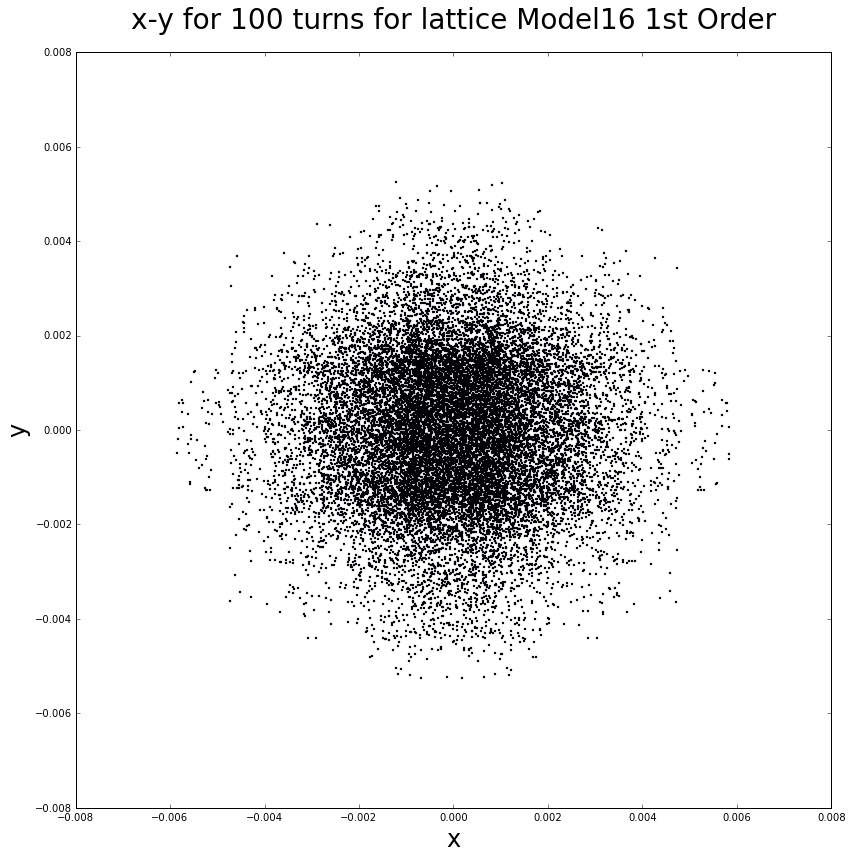

In [56]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = 'Model16 1st Order'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.01
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir

popts.save = True
popts.plots = ['x','y']
popts.num = 200
popts.scale = 2

singleparticle.plot_Poincare(popts)

##Introducing nonlinear elements with a 1st order propagator

Now let's consider a similar lattice with sextupoles added to the fodo sections. Moreover, we will tune the lattice near a resonance and ramp the sextupoles up to verify that the 1st order map cuts out much of the physics.

In [28]:
#load lattice
lattice = synergia.lattice.Mad8_reader().get_lattice("model16s", "/Users/ncook/Synergia_Tests/lattices/foborodobo_NL.lat")

length = lattice.get_length()
ref = lattice.get_reference_particle() #reference particle
ds = 0.01
nsteps = int(length/ds) +1 #calculate # of steps to take per turn
nsteps_per_element = nsteps/len(lattice.get_elements()) #not this isn't using future division, so returns int

In [9]:
name = 'model-S-strong'
order = 1
outputdir = 'order_'+str(order)+'_'+name

opts = make_opts(name, order, outputdir)
make_path(outputdir)

lattice_simulator = synergia.simulation.Lattice_simulator(lattice,
                                                              opts.map_order)
stepper= synergia.simulation.Independent_stepper(lattice, opts.map_order, opts.steps)

###Tune Lattice to 3rd integer resonance

In [11]:
#define a secondary lattice_simulator for this work

#stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
new_lattice_simulator = stepper.get_lattice_simulator()

x_tune0, y_tune0 = new_lattice_simulator.get_both_tunes()

x_tune1 = 0.33 #place on resonance
y_tune1 = y_tune0 #keep the same if possible
tune_tol = 1.0e-7; #need to define a tolerance for the fit

# get_fd_quads(lattice) reads input lattice and returns
# ( [list of focussing quad elements], [list of defocussing quad elements] )
def get_fd_quads(lattice):
    f_quads = []
    d_quads = []
    for elem in lattice.get_elements():
        if elem.get_type() == "quadrupole":
            k1 = elem.get_double_attribute("k1")
            if k1 > 0.0:
                f_quads.append(elem)
            elif k1 < 0.0:
                d_quads.append(elem)
    return (f_quads, d_quads)

#specify a set of magnets to be adjusted
f_quads, d_quads = get_fd_quads(lattice)

#use these magnets to adjust tune to specified final values
new_lattice_simulator.adjust_tunes(x_tune1,y_tune1,f_quads,d_quads,tune_tol)

#update lattice_simulator and get new lattice
new_lattice_simulator.update()
new_lattice = new_lattice_simulator.get_lattice()


#quick helper method
def print_strengths(elemslist, unique=True):
    strengths = []
    for elem in elemslist:
        if elem.get_type() == "quadrupole":
            strength = elem.get_double_attribute("k1")
            if unique:
                #only print new strengths
                if strength not in strengths:
                    print elem.get_name() + ' K: ' + str(elem.get_double_attribute("k1"))
                    strengths.append(strength)
                else:
                    pass
            else:
                #print all strengths
                print elem.get_name() + ' K: ' + str(elem.get_double_attribute("k1")) 

#Force define original lattice simulator
lattice = synergia.lattice.Mad8_reader().get_lattice("model16s", "/Users/ncook/Synergia_Tests/lattices/foborodobo_NL.lat")
stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()
print str(lattice_simulator.get_horizontal_tune()) + " is the original x-tune"

f_quads, d_quads = get_fd_quads(lattice)

print_strengths(f_quads)
print_strengths(d_quads)

print str(new_lattice_simulator.get_horizontal_tune()) + " is the new x-tune"

new_f_quads, new_d_quads = get_fd_quads(new_lattice)

print_strengths(new_f_quads)
print_strengths(new_d_quads)

0.0920106680371 is the original x-tune
f K: 0.714285714286
d K: -0.714285714286
0.329999998897 is the new x-tune
f K: 0.761214567067
d K: -0.729172681136


###Run simulation with re-tuned lattice

In [12]:
stepper= synergia.simulation.Independent_stepper(new_lattice, opts.map_order, opts.steps)

#Construct a matched bunch
myBunch = synergia.optics.generate_matched_bunch_transverse(
    new_lattice_simulator, opts.emitx, opts.emity, opts.stdz, 
    opts.dpop, opts.real_particles, 
    opts.macro_particles, opts.seed) 

#myBunch_2 = synergia.bunch.Bunch(new_lattice_simulator.get_lattice().get_reference_particle(),
#              num_macro_particles, num_real_particles, comm, z_period_length, bunch_index)
    
#Plot the bunch using my tools
#from base_diagnostics import pltbunch


# Define a bunch simulator
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

# Define a set of bunch diagnostics

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#tracking diagnostics - PER STEP
diagnostics = synergia.bunch.Diagnostics_track("track.h5", opts.tracked_particles, opts.output_dir)
#Track a particle twice per turn (e.g. every ~ num_steps/2 add the diagnostic)
bunch_simulator.add_per_step(diagnostics)

#particle diagnostics - PER TURN
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag)

In [14]:
#1st order map- ~3.5-4s per turn
propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator, opts.turns, opts.maxturns, 
                     opts.verbosity)

###Diagnostics

Again we will take a look at the single particle motion within the lattice. Although the lattice contains a strong nonlinear component via the sextupoles, the motion should reflect the linear map used by Synergia to propagate the beam. Thus, while resonance behavior may still be seen, the nonlinearities in phase space should not be present.

/Users/ncook/.virtualenvs/synergiaenv/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


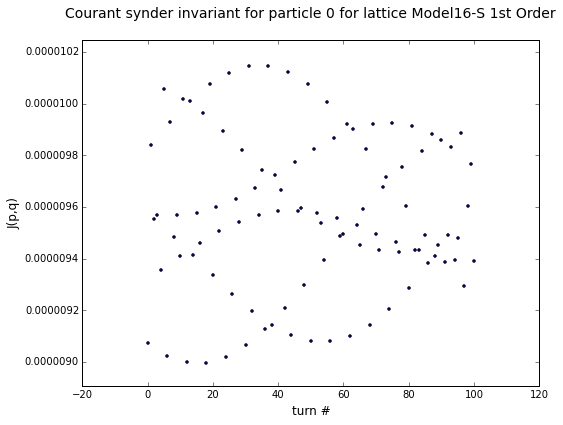

In [16]:
#clean up files first
cleanup(outputdir)

from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
#opts.inputfile = 'particles_0000.h5'
#opts.hcoord = 'x'
#opts.vcoord = 'xp'
popts.lattice_name = 'Model16-S 1st Order'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.01
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir


singleparticle.plot_Invariant(popts)

In [33]:
name = 'model-S-strong'
order = 1
outputdir = 'order_'+str(order)+'_'+name
opts.output_dir = outputdir

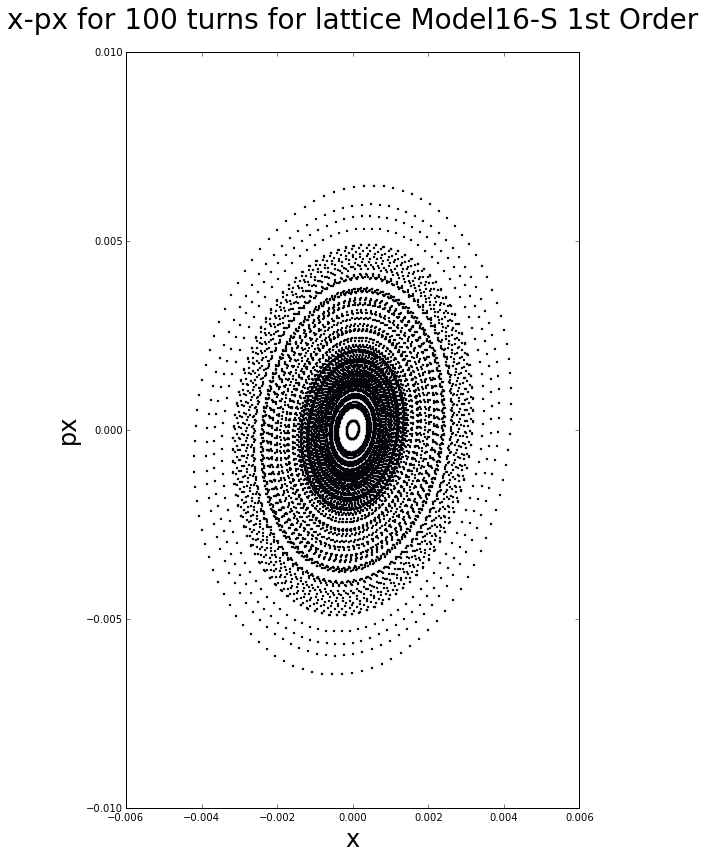

In [51]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = 'Model16-S 1st Order'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.01
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir

popts.save = True
popts.plots = ['x','px']
popts.num = 100
popts.scale = 2

singleparticle.plot_Poincare(popts)

No sign of nonlinear behavior, when compared with the 3rd order propagator results, which are shown and discussed in the next notebook.

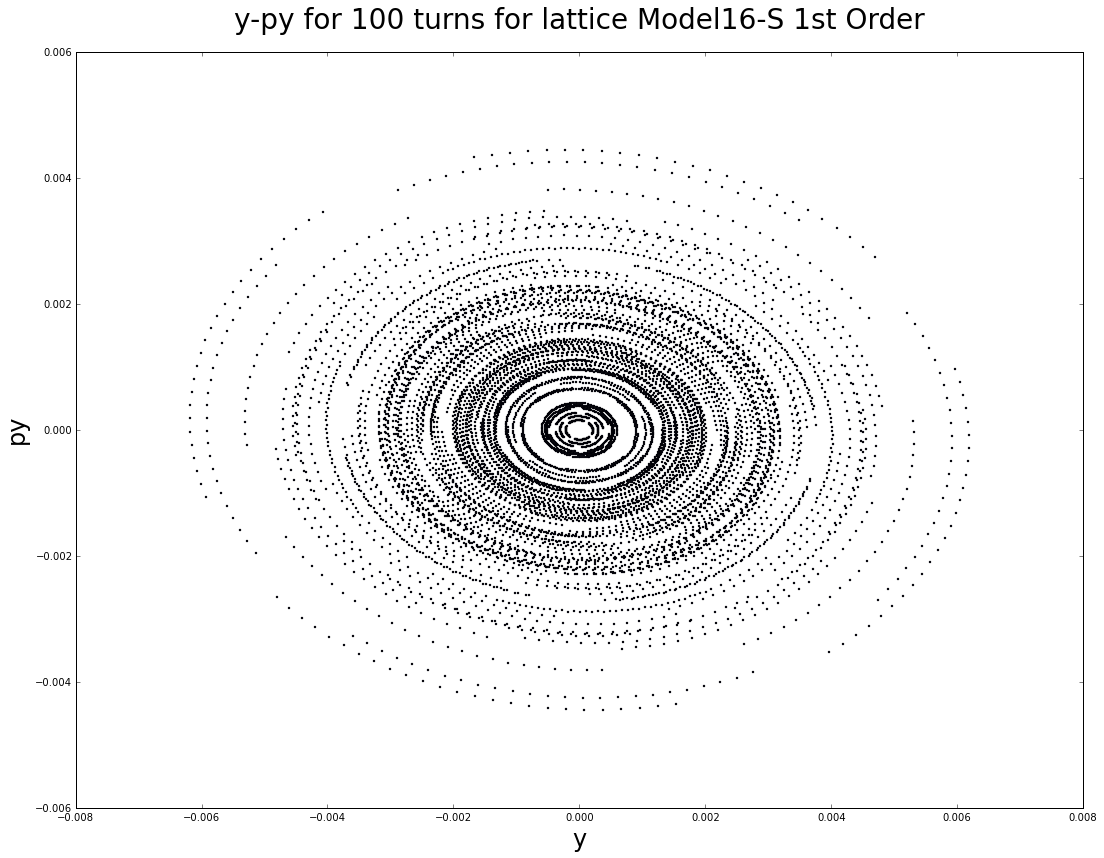

In [50]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = 'Model16-S 1st Order'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.01
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir

popts.save = True
popts.plots = ['y','py']
popts.num = 100
popts.scale = 2

singleparticle.plot_Poincare(popts)

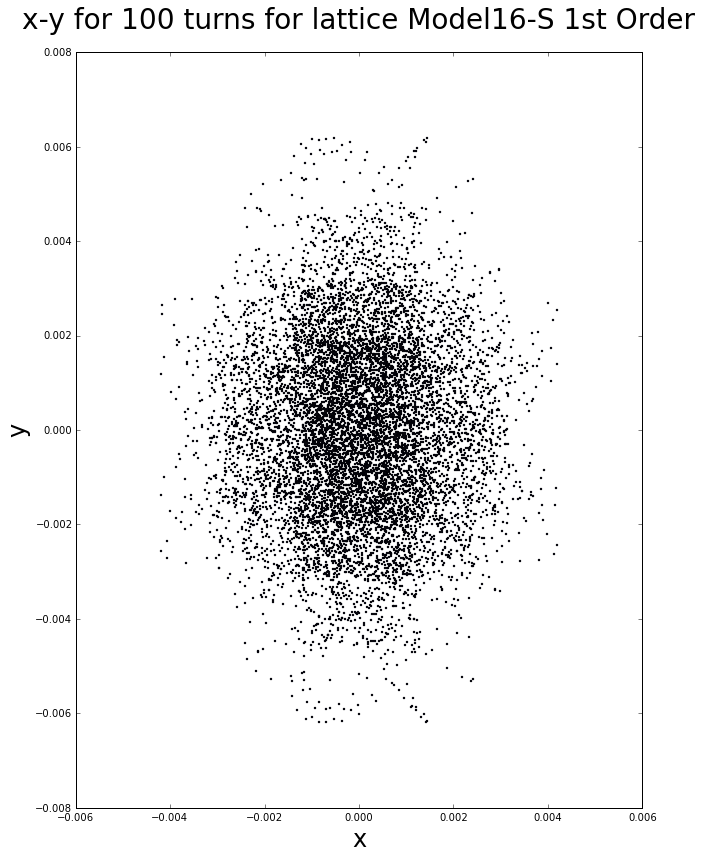

In [49]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = 'Model16-S 1st Order'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.01
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir

popts.save = True
popts.plots = ['x','y']
popts.num = 100
popts.scale = 2

singleparticle.plot_Poincare(popts)